In [3]:
#@title Copyright 2019 Google LLC. { display-mode: "form" }
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="http://colab.research.google.com/github/google/earthengine-community/blob/master/guides/linked/ee-api-colab-setup.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/google/earthengine-community/blob/master/guides/linked/ee-api-colab-setup.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Earth Engine Python API Colab Setup

This notebook demonstrates how to setup the Earth Engine Python API in Colab and provides several examples of how to print and visualize Earth Engine processed data.

## Import API and get credentials

The Earth Engine API is installed by default in Google Colaboratory so requires only importing and authenticating. These steps must be completed for each new Colab session, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity.

### Import the API

Run the following cell to import the API into your session.

In [1]:
import ee

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='gee-481701')

## Test the API

Test the API by printing the elevation of Mount Everest.

In [3]:

# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


# Real Code Now

In [112]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timedelta
import scipy.stats as stats


In [8]:
landsat_collections = {
    "L4": ("LANDSAT/LT04/C02/T1_L2", "ST_B6"),
    "L5": ("LANDSAT/LT05/C02/T1_L2", "ST_B6"),
    "L7": ("LANDSAT/LE07/C02/T1_L2", "ST_B6"),
    "L8": ("LANDSAT/LC08/C02/T1_L2", "ST_B10"),
    "L9": ("LANDSAT/LC09/C02/T1_L2", "ST_B10"),
}

In [9]:
lat, lon = 37.57027546, 126.9743997

point = ee.Geometry.Point(lon, lat)

In [21]:
input_df = pd.read_csv('/content/sample_data/points.csv')

# Functions

In [12]:
def mask_qa_pixel(img: ee.Image):
    # QA_PIXEL is the name of the fetched file that provides info
    # about pixel quality assurance
    qa = img.select("QA_PIXEL")

    # Fetch bits (0/1) describing if an environmental condition
    # is present
    cloud        = qa.bitwiseAnd(1 << 3).neq(0)
    cloud_shadow = qa.bitwiseAnd(1 << 4).neq(0)
    snow         = qa.bitwiseAnd(1 << 5).neq(0)
    cirrus       = qa.bitwiseAnd(1 << 2).neq(0)

    mask = (
        # Or condition for all bad conditions
        cloud
        .Or(cloud_shadow)
        .Or(snow)
        .Or(cirrus)

        # Not flips the conditions so any remaining pixels
        # have none of the conditions, and are "good" quality.
        .Not()
    )

    # Apply the mask to the input image
    return img.updateMask(mask)

In [13]:
def scale_lst(img, band):
    lst = (

        # Select the correct band, either ST_B6 or ST_B10
        img.select(band)
        .multiply(0.00341802)
        .add(149.0)
        .rename("LST_K")
    )

    # Add a new band to the original image, with the scaled LST
    return img.addBands(lst)

In [15]:
def extract_lst(collection_id, band, point, mission):
    col = (
        ee.ImageCollection(collection_id)
        .filterBounds(point)

        # Toggle this mask for more but less trustworthy data
        .map(mask_qa_pixel)

        # Apply the scaling of LST to every image, run server-side
        .map(lambda img: scale_lst(img, band))
    )

    def sample_image(img):
        sampled = img.select("LST_K").sample(
            # Sample exactly at the given point
            region=point,
            scale=30,
            numPixels=1,
            geometries=False
        )

        return ee.Feature(None, {
            "mission": mission,
            "image_id": img.id(),
            "time": ee.Date(img.get("system:time_start")).format("YYYY-MM-dd HH:mm:ss"),
            "lst_k": ee.Algorithms.If(
                sampled.size().gt(0),
                sampled.first().get("LST_K"),
                None
            )
        })

    return col.map(sample_image)

In [ ]:
def mask_qa_pixel(img: ee.Image):
    # QA_PIXEL is the name of the fetched file that provides info
    # about pixel quality assurance
    qa = img.select("QA_PIXEL")

    # Fetch bits (0/1) describing if an environmental condition
    # is present
    cloud        = qa.bitwiseAnd(1 << 3).neq(0)
    cloud_shadow = qa.bitwiseAnd(1 << 4).neq(0)
    snow         = qa.bitwiseAnd(1 << 5).neq(0)
    cirrus       = qa.bitwiseAnd(1 << 2).neq(0)

    mask = (
        # Or condition for all bad conditions
        cloud
        .Or(cloud_shadow)
        .Or(snow)
        .Or(cirrus)

        # Not flips the conditions so any remaining pixels
        # have none of the conditions, and are "good" quality.
        .Not()
    )

    # Apply the mask to the input image
    return img.updateMask(mask)

In [ ]:
def scale_lst(img, band):
    lst = (

        # Select the correct band, either ST_B6 or ST_B10
        img.select(band)
        .multiply(0.00341802)
        .add(149.0)
        .rename("LST_K")
    )

    # Add a new band to the original image, with the scaled LST
    return img.addBands(lst)

In [ ]:
def extract_lst(collection_id, band, point, mission):
    col = (
        ee.ImageCollection(collection_id)
        .filterBounds(point)

        # Toggle this mask for more but less trustworthy data
        .map(mask_qa_pixel)

        # Apply the scaling of LST to every image, run server-side
        .map(lambda img: scale_lst(img, band))
    )

    def sample_image(img):
        sampled = img.select("LST_K").sample(
            # Sample exactly at the given point
            region=point,
            scale=30,
            numPixels=1,
            geometries=False
        )

        return ee.Feature(None, {
            "mission": mission,
            "image_id": img.id(),
            "time": ee.Date(img.get("system:time_start")).format("YYYY-MM-dd HH:mm:ss"),
            "lst_k": ee.Algorithms.If(
                sampled.size().gt(0),
                sampled.first().get("LST_K"),
                None
            )
        })

    return col.map(sample_image)

# Single coordinate data collection

In [ ]:
features = []

for mission, (collection_id, band) in landsat_collections.items():
    fc = extract_lst(collection_id, band, point, mission)
    features.append(fc)

merged = ee.FeatureCollection(features).flatten()

In [ ]:
results = merged.getInfo()

In [ ]:
lst_records = []
times = []
for feature in results["features"]:
    data = feature["properties"]

    lst_records.append(data.get("lst_k", None))
    times.append(data["time"])

# Visualize

In [ ]:
# 2. Convert time strings to datetime objects
# The format string '%Y-%m-%d %H:%M:%S' tells strptime how to parse the string
dates = [datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S') for dt_str in times]

# 3. Plot the data
fig, ax = plt.subplots(figsize=(10, 6)) # Create a figure and an axes object
ax.scatter(dates, lst_records, marker='o', linestyle='-')

# 4. Format the x-axis for better readability (optional but recommended for time series)
# Rotate and align the x-axis labels
fig.autofmt_xdate()
# Optionally, set a specific date format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# 5. Add labels and a title
ax.set_xlabel("Time")
ax.set_ylabel("Raw Values")
ax.set_title("Time Series Plot")

# 6. Display the plot
plt.show()

In [ ]:
# 2. Convert time strings to datetime objects
# The format string '%Y-%m-%d %H:%M:%S' tells strptime how to parse the string
dates = [datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S') for dt_str in times]

start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)

filtered_dates = []
filtered_records = []

for date, record in zip(dates, lst_records):
    if start_date <= date <= end_date:
        filtered_dates.append(date)
        filtered_records.append(record)

# 3. Plot the data
fig, ax = plt.subplots(figsize=(10, 6)) # Create a figure and an axes object
# ax.scatter(dates, lst_records, marker='o', linestyle='-')
ax.scatter(filtered_dates, filtered_records, marker='o', linestyle='-')

# 4. Format the x-axis for better readability (optional but recommended for time series)
# Rotate and align the x-axis labels
fig.autofmt_xdate()
# Optionally, set a specific date format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# 5. Add labels and a title
ax.set_xlabel("Time")
ax.set_ylabel("Raw Values")
ax.set_title("Time Series Plot")

# 6. Display the plot
plt.show()

# Model data with sine fit

In [85]:
def sine_model(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

In [ ]:
print(len(filtered_dates) == len(filtered_records))
print(filtered_dates)
print(filtered_records)

In [ ]:
dates = np.array(filtered_dates)
values = np.array(filtered_records, dtype=float)

mask = ~np.isnan(values)   # None → NaN when cast to float
dates_fit = dates[mask]
values_fit = values[mask]

t0 = dates_fit[0]
t = np.array([(d - t0).total_seconds() / 86400 for d in dates_fit])

A_guess = (values_fit.max() - values_fit.min()) / 2
C_guess = values_fit.mean()
f_guess = 1 / 365      # yearly cycle (adjust if needed)
phi_guess = 0

p0 = [A_guess, f_guess, phi_guess, C_guess]

In [ ]:
params, cov = curve_fit(
    sine_model,
    t,
    values_fit,
    p0=p0
)

A, f, phi, C = params
print(A, f, phi, C)

# Graphing

In [ ]:
# Dense grid of datetimes
dates_dense = np.array([
    dates_fit.min() + timedelta(seconds=s)
    for s in np.linspace(
        0,
        (dates_fit.max() - dates_fit.min()).total_seconds(),
        1000
    )
])

In [ ]:
t_dense = np.array([(d - t0).total_seconds() / 86400 for d in dates_dense])
y_fit = sine_model(t_dense, A, f, phi, C)

fig, ax = plt.subplots(figsize=(10, 6))

# Original data
ax.scatter(filtered_dates, filtered_records,
           color='tab:blue', label='Data')

# Fitted sine curve
ax.plot(dates_dense, y_fit,
        color='tab:red', linewidth=2, label='Sine fit')

# Formatting
fig.autofmt_xdate()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

ax.set_xlabel("Time")
ax.set_ylabel("Raw Values")
ax.set_title("Time Series with Sine Fit")
ax.legend()

plt.show()

In [ ]:
columns = ['lat', 'long', 'time', 'LST']
export_df = pd.DataFrame(columns=columns)

# Storing Data

In [16]:
columns = ["lat", "long", "time", "LST", "distance"]
export_df = pd.DataFrame(columns=columns)

In [17]:
export_df

,lat,long,time,LST,distance


# Loop over all points

In [30]:
def df_to_points_fc(df):
    feats = []
    for _, r in df.iterrows():
        geom = ee.Geometry.Point(float(r["long"]), float(r["lat"]))
        feats.append(
            ee.Feature(geom, {
                "lat": float(r["lat"]),
                "long": float(r["long"]),
                "distance": float(r["distance"])
            })
        )
    return ee.FeatureCollection(feats)

points_fc = df_to_points_fc(input_df)

In [42]:
city_geom = points_fc.geometry().convexHull(maxError=1)

In [44]:
def sample_landsat_collection(collection_id, band, mission, city_geom, points_fc):
    col = (
        ee.ImageCollection(collection_id)
        .filterBounds(city_geom)     # ONE image per city per overpass
        .map(mask_qa_pixel)
        .map(lambda img: scale_lst(img, band))
    )

    def per_image(img):
        samples = img.select("LST_K").sampleRegions(
            collection=points_fc,
            geometries=False,
            scale=None    # native projection → avoids EPSG errors
        )

        return samples.map(lambda f: f.set({
            "mission": mission,
            "image_id": img.id(),
            "time": ee.Date(img.get("system:time_start"))
                        .format("YYYY-MM-dd HH:mm:ss")
        }))

    return col.map(per_image).flatten()

In [45]:
collections = []

for mission, (collection_id, band) in landsat_collections.items():
    fc = sample_landsat_collection(
        collection_id, band, mission, city_geom, points_fc
    )
    collections.append(fc)

final_fc = ee.FeatureCollection(collections).flatten()

In [46]:
ee.batch.Export.table.toDrive(
    collection=final_fc,
    description="landsat_lst_city_points",
    fileFormat="CSV"
).start()

In [47]:
ee.data.getTaskStatus("NJZL3G7HOT3CED4GVMESTRNY")

[{'state': 'RUNNING',
  'description': 'landsat_lst_city_points',
  'priority': 100,
  'creation_timestamp_ms': 1769370480688,
  'update_timestamp_ms': 1769372550848,
  'start_timestamp_ms': 1769370490387,
  'task_type': 'EXPORT_FEATURES',
  'attempt': 1,
  'batch_eecu_usage_seconds': 1095.403930664,
  'id': 'NJZL3G7HOT3CED4GVMESTRNY',
  'name': 'projects/gee-481701/operations/NJZL3G7HOT3CED4GVMESTRNY'}]

In [48]:
ee.data.listOperations()


[{'name': 'projects/gee-481701/operations/NJZL3G7HOT3CED4GVMESTRNY',
  'metadata': {'@type': 'type.googleapis.com/google.earthengine.v1alpha.OperationMetadata',
   'state': 'RUNNING',
   'description': 'landsat_lst_city_points',
   'priority': 100,
   'createTime': '2026-01-25T19:48:00.688008Z',
   'updateTime': '2026-01-25T20:22:50.908955Z',
   'startTime': '2026-01-25T19:48:10.387269Z',
   'type': 'EXPORT_FEATURES',
   'attempt': 1,
   'batchEecuUsageSeconds': 1100.581542968}},
 {'name': 'projects/gee-481701/operations/JWXCXYBEDBAQZOGY2ZZSD7N4',
  'metadata': {'@type': 'type.googleapis.com/google.earthengine.v1alpha.OperationMetadata',
   'state': 'FAILED',
   'description': 'landsat_lst_all_points',
   'priority': 100,
   'createTime': '2026-01-25T07:10:07.500586Z',
   'updateTime': '2026-01-25T07:11:35.224310Z',
   'startTime': '2026-01-25T07:10:20.657698Z',
   'endTime': '2026-01-25T07:11:35.224310Z',
   'type': 'EXPORT_FEATURES',
   'attempt': 1,
   'batchEecuUsageSeconds': 95.50

# Reading Export CSV

In [9]:
export_csv = pd.read_csv("/content/sample_data/landsat_lst_city_points.csv")

In [31]:
export_csv[0:5]

,system:index,LST_K,distance,image_id,lat,long,mission,time,.geo
0,0_LT04_116034_19881224_2504_0,272.622947,317.553292,LT04_116034_19881224,37.572606,127.013452,L4,1988-12-24 01:43:00,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,0_LT04_116034_19881224_2526_0,272.622947,317.478476,LT04_116034_19881224,37.572608,127.013792,L4,1988-12-24 01:43:00,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,0_LT04_116034_19881224_2527_0,272.622947,287.478569,LT04_116034_19881224,37.572337,127.013794,L4,1988-12-24 01:43:00,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,0_LT04_116034_19881224_2549_0,272.718652,287.403753,LT04_116034_19881224,37.572339,127.014134,L4,1988-12-24 01:43:00,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,0_LT04_116034_19881224_2550_0,272.718652,257.403847,LT04_116034_19881224,37.572068,127.014135,L4,1988-12-24 01:43:00,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [20]:
export_csv["distance"].nunique()

4628

In [22]:
len(input_df)

4628

In [28]:
export_csv.columns

Index(['system:index', 'LST_K', 'distance', 'image_id', 'lat', 'long',
       'mission', 'time', '.geo'],
      dtype='object')

In [24]:
export_csv_copy = export_csv.copy()

In [29]:
export_csv_copy.groupby(['lat','long']).size().reset_index().rename(columns={0:'count'})

,lat,long,count
0,37.565193,126.987004,531
1,37.565195,126.987344,537
2,37.565196,126.987684,512
3,37.565198,126.988023,512
4,37.565199,126.988363,512
...,...,...,...
4623,37.574877,127.040277,595
4624,37.574878,127.040617,606
4625,37.574879,127.040957,558
4626,37.574881,127.041296,605


In [33]:
export_csv["distance"].value_counts()

,count
distance,
288.059684,674
320.772371,674
256.290609,671
226.346148,669
286.235071,669
...,...
95.446411,465
211.468217,464
215.114519,463


In [34]:
export_csv["distance"][0:5]

,distance
0,317.553292
1,317.478476
2,287.478569
3,287.403753
4,257.403847


In [39]:
export_csv['distance'][0]

np.float64(317.553291770426)

In [38]:
np.where(export_csv['distance'] == np.float64(317.553291770426))[0].tolist()

[0,
 2274,
 6790,
 11418,
 16046,
 20864,
 26689,
 33350,
 37080,
 44957,
 49851,
 55410,
 59208,
 63235,
 67851,
 70765,
 74458,
 79596,
 85911,
 89348,
 93159,
 97566,
 102194,
 106265,
 110218,
 113851,
 119594,
 124207,
 128835,
 133463,
 138091,
 141771,
 145906,
 150534,
 154154,
 156469,
 159070,
 163041,
 167661,
 172459,
 177087,
 181703,
 186099,
 190281,
 194520,
 199103,
 203717,
 208345,
 211510,
 214764,
 218361,
 220325,
 223065,
 227565,
 232193,
 238270,
 245966,
 250510,
 252943,
 255449,
 261855,
 269154,
 273782,
 278213,
 283442,
 288023,
 291725,
 293488,
 300530,
 305022,
 309414,
 313609,
 314343,
 316736,
 321049,
 325677,
 329212,
 333459,
 338086,
 342714,
 347342,
 351268,
 354944,
 359572,
 363024,
 366801,
 370070,
 374826,
 379454,
 383934,
 388245,
 396793,
 400759,
 404008,
 407172,
 410356,
 413212,
 415913,
 419554,
 423179,
 425462,
 428925,
 434292,
 438811,
 442881,
 445792,
 448881,
 453491,
 458110,
 462738,
 470133,
 474631,
 479259,
 484298,
 4

# Group the df by lat/long pair coordinates, sort each group by time

In [43]:
export_csv_copy['time'] = pd.to_datetime(export_csv_copy['time'])

In [46]:
export_csv_copy = export_csv_copy.sort_values(
    by=['lat', 'long', 'time'],
    ascending=[True, True, True]
).reset_index(drop=True)

In [47]:
export_csv_copy.groupby(['lat', 'long'])['time'].is_monotonic_increasing.all()

np.True_

In [48]:
export_csv_copy

,system:index,LST_K,distance,image_id,lat,long,mission,time,.geo
0,1_LT05_116034_19840730_797_0,314.209997,326.113118,LT05_116034_19840730,37.565193,126.987004,L5,1984-07-30 01:40:17,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1_LT05_116034_19850311_797_0,278.949702,326.113118,LT05_116034_19850311,37.565193,126.987004,L5,1985-03-11 01:41:28,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,1_LT05_116034_19860226_797_0,271.963270,326.113118,LT05_116034_19860226,37.565193,126.987004,L5,1986-02-26 01:37:29,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,1_LT05_116034_19860415_797_0,300.356762,326.113118,LT05_116034_19860415,37.565193,126.987004,L5,1986-04-15 01:36:29,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,1_LT05_116034_19860517_797_0,302.188820,326.113118,LT05_116034_19860517,37.565193,126.987004,L5,1986-05-17 01:35:40,"{""type"":""MultiPoint"",""coordinates"":[]}"
...,...,...,...,...,...,...,...,...,...
2644639,3_LC08_116034_20251104_4458_0,290.868338,325.944916,LC08_116034_20251104,37.574882,127.041636,L8,2025-11-04 02:11:21,"{""type"":""MultiPoint"",""coordinates"":[]}"
2644640,4_LC09_116034_20251112_4458_0,290.212078,325.944916,LC09_116034_20251112,37.574882,127.041636,L9,2025-11-12 02:11:26,"{""type"":""MultiPoint"",""coordinates"":[]}"
2644641,4_LC09_116034_20251128_4458_0,281.089383,325.944916,LC09_116034_20251128,37.574882,127.041636,L9,2025-11-28 02:11:24,"{""type"":""MultiPoint"",""coordinates"":[]}"
2644642,3_LC08_116034_20251222_4458_0,274.424244,325.944916,LC08_116034_20251222,37.574882,127.041636,L8,2025-12-22 02:11:18,"{""type"":""MultiPoint"",""coordinates"":[]}"


# Get sine fit table

In [49]:
sine_columns = ["lat", "long", "year", "A", "f", "phi", "C"]

In [51]:
sine_df = pd.DataFrame(columns=sine_columns)

In [80]:
export_csv_copy.columns

Index(['system:index', 'LST_K', 'distance', 'image_id', 'lat', 'long',
       'mission', 'time', '.geo'],
      dtype='object')

In [52]:
sine_df

,lat,long,year,A,f,phi,C


In [54]:
export_csv_copy

,system:index,LST_K,distance,image_id,lat,long,mission,time,.geo
0,1_LT05_116034_19840730_797_0,314.209997,326.113118,LT05_116034_19840730,37.565193,126.987004,L5,1984-07-30 01:40:17,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1_LT05_116034_19850311_797_0,278.949702,326.113118,LT05_116034_19850311,37.565193,126.987004,L5,1985-03-11 01:41:28,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,1_LT05_116034_19860226_797_0,271.963270,326.113118,LT05_116034_19860226,37.565193,126.987004,L5,1986-02-26 01:37:29,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,1_LT05_116034_19860415_797_0,300.356762,326.113118,LT05_116034_19860415,37.565193,126.987004,L5,1986-04-15 01:36:29,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,1_LT05_116034_19860517_797_0,302.188820,326.113118,LT05_116034_19860517,37.565193,126.987004,L5,1986-05-17 01:35:40,"{""type"":""MultiPoint"",""coordinates"":[]}"
...,...,...,...,...,...,...,...,...,...
2644639,3_LC08_116034_20251104_4458_0,290.868338,325.944916,LC08_116034_20251104,37.574882,127.041636,L8,2025-11-04 02:11:21,"{""type"":""MultiPoint"",""coordinates"":[]}"
2644640,4_LC09_116034_20251112_4458_0,290.212078,325.944916,LC09_116034_20251112,37.574882,127.041636,L9,2025-11-12 02:11:26,"{""type"":""MultiPoint"",""coordinates"":[]}"
2644641,4_LC09_116034_20251128_4458_0,281.089383,325.944916,LC09_116034_20251128,37.574882,127.041636,L9,2025-11-28 02:11:24,"{""type"":""MultiPoint"",""coordinates"":[]}"
2644642,3_LC08_116034_20251222_4458_0,274.424244,325.944916,LC08_116034_20251222,37.574882,127.041636,L8,2025-12-22 02:11:18,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [57]:
export_csv_copy['distance'][0]

np.float64(326.11311782017)

In [59]:
np.where(export_csv_copy['distance'] == np.float64(326.11311782017))[0].tolist()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [62]:
export_csv_copy['distance'][530]

np.float64(326.11311782017)

In [66]:
test_dates = np.array(export_csv_copy['time'][0:531])

In [67]:
test_values = np.array(export_csv_copy['LST_K'][0:531])

In [68]:
np.sum(np.isnan(test_values))

np.int64(0)

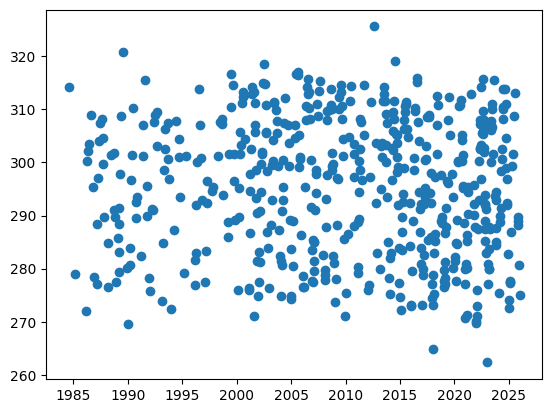

In [81]:
plt.scatter(test_dates, test_values)
plt.show()

In [82]:
export_csv_copy['time'] = pd.to_datetime(export_csv_copy['time'])
export_csv_copy['year'] = export_csv_copy['time'].dt.year

In [83]:
export_csv_copy

,system:index,LST_K,distance,image_id,lat,long,mission,time,.geo,year
0,1_LT05_116034_19840730_797_0,314.209997,326.113118,LT05_116034_19840730,37.565193,126.987004,L5,1984-07-30 01:40:17,"{""type"":""MultiPoint"",""coordinates"":[]}",1984
1,1_LT05_116034_19850311_797_0,278.949702,326.113118,LT05_116034_19850311,37.565193,126.987004,L5,1985-03-11 01:41:28,"{""type"":""MultiPoint"",""coordinates"":[]}",1985
2,1_LT05_116034_19860226_797_0,271.963270,326.113118,LT05_116034_19860226,37.565193,126.987004,L5,1986-02-26 01:37:29,"{""type"":""MultiPoint"",""coordinates"":[]}",1986
3,1_LT05_116034_19860415_797_0,300.356762,326.113118,LT05_116034_19860415,37.565193,126.987004,L5,1986-04-15 01:36:29,"{""type"":""MultiPoint"",""coordinates"":[]}",1986
4,1_LT05_116034_19860517_797_0,302.188820,326.113118,LT05_116034_19860517,37.565193,126.987004,L5,1986-05-17 01:35:40,"{""type"":""MultiPoint"",""coordinates"":[]}",1986
...,...,...,...,...,...,...,...,...,...,...
2644639,3_LC08_116034_20251104_4458_0,290.868338,325.944916,LC08_116034_20251104,37.574882,127.041636,L8,2025-11-04 02:11:21,"{""type"":""MultiPoint"",""coordinates"":[]}",2025
2644640,4_LC09_116034_20251112_4458_0,290.212078,325.944916,LC09_116034_20251112,37.574882,127.041636,L9,2025-11-12 02:11:26,"{""type"":""MultiPoint"",""coordinates"":[]}",2025
2644641,4_LC09_116034_20251128_4458_0,281.089383,325.944916,LC09_116034_20251128,37.574882,127.041636,L9,2025-11-28 02:11:24,"{""type"":""MultiPoint"",""coordinates"":[]}",2025
2644642,3_LC08_116034_20251222_4458_0,274.424244,325.944916,LC08_116034_20251222,37.574882,127.041636,L8,2025-12-22 02:11:18,"{""type"":""MultiPoint"",""coordinates"":[]}",2025


In [92]:
len(export_csv_copy.groupby(['lat', 'long']))

4628

In [93]:
rows = []  # collect rows first (much faster than appending to df)

runtime_error_count = 0
coordinate_count = 0
for (lat, lon), coord_df in export_csv_copy.groupby(['lat', 'long']):
    if (coordinate_count % 100 == 0):
        print(coordinate_count)
    for year, year_df in coord_df.groupby('year'):
        # need enough points to fit a sine, 5 points chosen arbitrarily
        if len(year_df) < 5:
            continue

        test_dates = year_df['time'].to_numpy()
        test_values = year_df['LST_K'].to_numpy()

        # convert time to days since first observation
        t0 = test_dates[0]
        t = np.array(
            [((d - t0) / np.timedelta64(1, 's')) / 86400 for d in test_dates]
        )

        # initial guesses
        A_guess = (test_values.max() - test_values.min()) / 2
        C_guess = test_values.mean()
        f_guess = 1 / 365
        phi_guess = 0
        p0 = [A_guess, f_guess, phi_guess, C_guess]

        try:
            params, cov = curve_fit(
                sine_model,
                t,
                test_values,
                p0=p0,
                maxfev=10000
            )

            A, f, phi, C = params

            rows.append({
                "lat": lat,
                "long": lon,
                "year": year,
                "A": A,
                "f": f,
                "phi": phi,
                "C": C
            })

        except RuntimeError:
            # fit failed — skip this year
            runtime_error_count += 1
            continue
    coordinate_count += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600


In [94]:
sine_df = pd.DataFrame(rows)

In [95]:
sine_df

,lat,long,year,A,f,phi,C
0,37.565193,126.987004,1986,48755.129733,0.000041,1.533836,-48446.254029
1,37.565193,126.987004,1987,50368.766502,0.000041,1.535703,-50058.866769
2,37.565193,126.987004,1988,33692.057573,0.000048,1.529799,-33386.544274
3,37.565193,126.987004,1989,19.869800,0.003109,-1.357817,301.748036
4,37.565193,126.987004,1990,21.411413,0.002333,-1.020308,288.478514
...,...,...,...,...,...,...,...
180035,37.574882,127.041636,2021,24.414483,0.002203,5.248312,289.834540
180036,37.574882,127.041636,2022,37.725811,0.001623,-0.284917,275.273167
180037,37.574882,127.041636,2023,21.067508,0.002452,-1.030775,292.311670
180038,37.574882,127.041636,2024,22.473501,0.002433,-1.175560,295.178531


# Visualize sine_df

In [96]:
print(sine_df['lat'][0])
print(sine_df['long'][0])

37.5651932317
126.9870041665


In [97]:
point_1_lat_mask = sine_df['lat'] == 37.5651932317
point_1_long_mask = sine_df['long'] == 126.9870041665
point_1_data = sine_df[point_1_lat_mask & point_1_long_mask]

In [99]:
point_1_data

,lat,long,year,A,f,phi,C
0,37.565193,126.987004,1986,48755.129733,0.000041,1.533836,-48446.254029
1,37.565193,126.987004,1987,50368.766502,0.000041,1.535703,-50058.866769
2,37.565193,126.987004,1988,33692.057573,0.000048,1.529799,-33386.544274
3,37.565193,126.987004,1989,19.869800,0.003109,-1.357817,301.748036
4,37.565193,126.987004,1990,21.411413,0.002333,-1.020308,288.478514
5,37.565193,126.987004,1991,19.181576,0.003180,-0.993718,296.916165
6,37.565193,126.987004,1992,18.053384,0.002626,-1.699192,294.121845
7,37.565193,126.987004,1993,240.361605,0.000613,1.028081,69.397060
8,37.565193,126.987004,1994,24342.336865,0.000065,1.524895,-24029.590377
9,37.565193,126.987004,1996,17.327302,0.002923,-1.190362,294.076770


In [109]:
point_1_outlier_mask = point_1_data['C'] > 280
point_1_data = point_1_data[point_1_outlier_mask]

In [110]:
point_1_data

,lat,long,year,A,f,phi,C
3,37.565193,126.987004,1989,19.869800,0.003109,-1.357817,301.748036
4,37.565193,126.987004,1990,21.411413,0.002333,-1.020308,288.478514
5,37.565193,126.987004,1991,19.181576,0.003180,-0.993718,296.916165
6,37.565193,126.987004,1992,18.053384,0.002626,-1.699192,294.121845
9,37.565193,126.987004,1996,17.327302,0.002923,-1.190362,294.076770
12,37.565193,126.987004,1999,15.831564,0.003520,-1.568550,301.603489
15,37.565193,126.987004,2002,20.084628,0.002772,-1.631377,298.591862
17,37.565193,126.987004,2004,20.242575,0.002671,-1.691777,299.666486
18,37.565193,126.987004,2005,22.463957,0.002578,-1.551082,296.674649
19,37.565193,126.987004,2006,20.257173,0.002854,-1.569785,297.632060


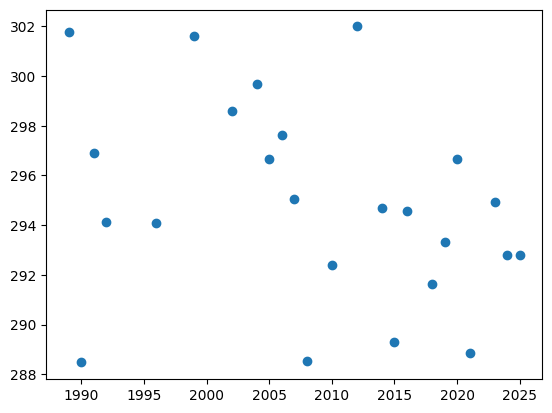

In [111]:
plt.scatter(point_1_data['year'], point_1_data['C'])
plt.show()

In [113]:
slope, intercept, r_value, p_value, std_err = stats.linregress(point_1_data['year'], point_1_data['C'])

In [114]:
reg_x = np.linspace(min(point_1_data['year']), max(point_1_data['year']), 10)
reg_y = slope * reg_x + intercept

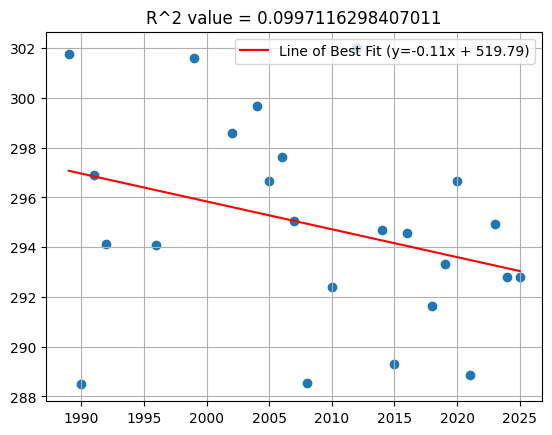

In [121]:
plt.scatter(point_1_data['year'], point_1_data['C'])
plt.plot(reg_x, reg_y, color='red', label=f'Line of Best Fit (y={slope:.2f}x + {intercept:.2f})')

plt.title('R^2 value = ' + str(r_value**2))
plt.legend()
plt.grid(True)
plt.show()

# Repeat visualize with closest point

In [126]:
export_csv_copy['distance'].min()

0.0791545203694381

In [127]:
min_distance = export_csv_copy['distance'] == 0.0791545203694381

In [139]:
selected_point = export_csv_copy[min_distance].iloc[0]

In [141]:
print(selected_point['lat'], selected_point['long'])

37.568695055 126.9839227376


In [142]:
point_2_lat_mask = sine_df['lat'] == 37.568695055
point_2_long_mask = sine_df['long'] == 126.9839227376
point_2_data = sine_df[point_2_lat_mask & point_2_long_mask]

In [143]:
point_2_data

,lat,long,year,A,f,phi,C
54268,37.568695,126.983923,1986,61411.346922,0.000034,1.540018,-61104.907797
54269,37.568695,126.983923,1987,33411.534773,0.000048,1.528191,-33101.523354
54270,37.568695,126.983923,1988,17580.477232,0.000063,1.516192,-17276.227684
54271,37.568695,126.983923,1989,21.521001,0.002881,-1.635548,299.067391
54272,37.568695,126.983923,1990,28.757072,0.001702,-0.281452,278.564033
54273,37.568695,126.983923,1991,19.455961,0.002710,-1.102777,292.745404
54274,37.568695,126.983923,1992,18.425410,0.002663,-1.199613,293.753868
54275,37.568695,126.983923,1993,19.459643,0.002710,-1.609168,293.199736
54276,37.568695,126.983923,1994,10020.262341,0.000102,1.498699,-9707.297126
54277,37.568695,126.983923,1996,19.073064,0.002683,-0.977959,292.726241


In [144]:
point_2_outlier_mask = point_2_data['C'] > 0
point_2_data = point_2_data[point_2_outlier_mask]

In [145]:
point_2_data

,lat,long,year,A,f,phi,C
54271,37.568695,126.983923,1989,21.521001,0.002881,-1.635548,299.067391
54272,37.568695,126.983923,1990,28.757072,0.001702,-0.281452,278.564033
54273,37.568695,126.983923,1991,19.455961,0.002710,-1.102777,292.745404
54274,37.568695,126.983923,1992,18.425410,0.002663,-1.199613,293.753868
54275,37.568695,126.983923,1993,19.459643,0.002710,-1.609168,293.199736
54277,37.568695,126.983923,1996,19.073064,0.002683,-0.977959,292.726241
54280,37.568695,126.983923,1999,15.766002,0.003236,-1.206669,299.633491
54281,37.568695,126.983923,2000,36.758111,0.001738,-0.046437,277.549491
54283,37.568695,126.983923,2002,21.342012,0.002641,-0.821913,296.031165
54284,37.568695,126.983923,2003,23.185979,0.002075,-0.017722,289.019202


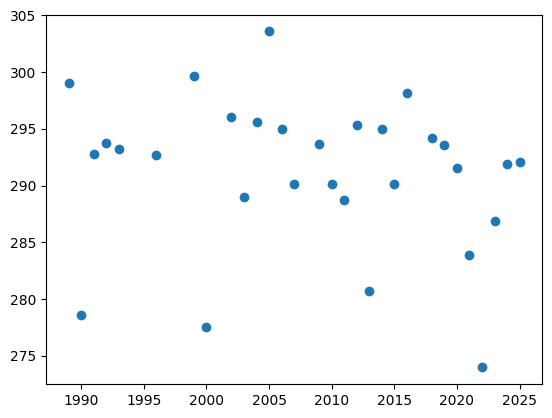

In [146]:
plt.scatter(point_2_data['year'], point_2_data['C'])
plt.show()

In [147]:
slope, intercept, r_value, p_value, std_err = stats.linregress(point_2_data['year'], point_2_data['C'])

In [148]:
reg_x = np.linspace(min(point_2_data['year']), max(point_2_data['year']), 10)
reg_y = slope * reg_x + intercept

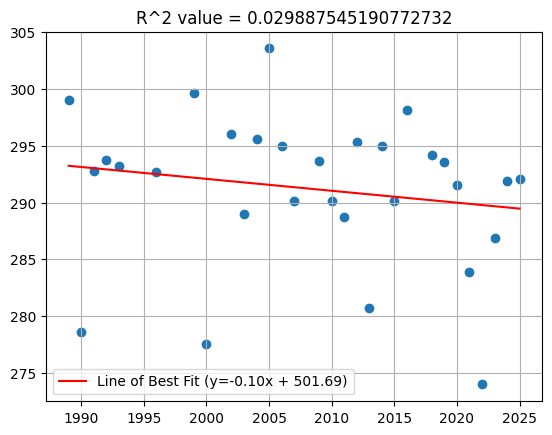

In [149]:
plt.scatter(point_2_data['year'], point_2_data['C'])
plt.plot(reg_x, reg_y, color='red', label=f'Line of Best Fit (y={slope:.2f}x + {intercept:.2f})')

plt.title('R^2 value = ' + str(r_value**2))
plt.legend()
plt.grid(True)
plt.show()

# Statistically remove outliers

In [150]:
def remove_outliers_iqr(df, column_name):
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to keep only non-outliers
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return df_filtered

In [151]:
point_2_data_cleaned = remove_outliers_iqr(point_2_data, 'C')

In [153]:
len(point_2_data) - len(point_2_data_cleaned)

5

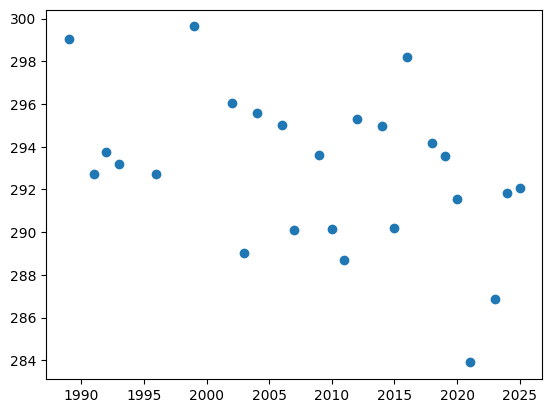

In [154]:
plt.scatter(point_2_data_cleaned['year'], point_2_data_cleaned['C'])
plt.show()

In [155]:
slope, intercept, r_value, p_value, std_err = stats.linregress(point_2_data_cleaned['year'], point_2_data_cleaned['C'])

In [156]:
reg_x = np.linspace(min(point_2_data_cleaned['year']), max(point_2_data_cleaned['year']), 10)
reg_y = slope * reg_x + intercept

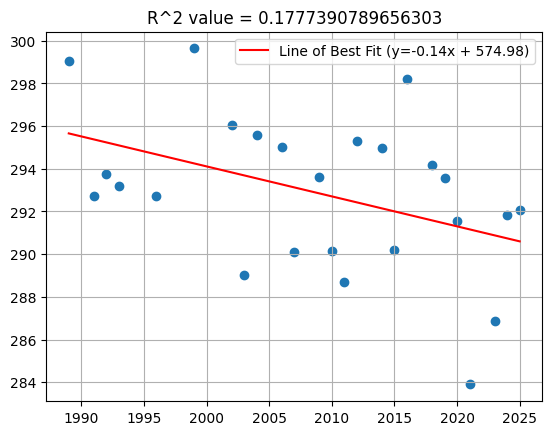

In [157]:
plt.scatter(point_2_data_cleaned['year'], point_2_data_cleaned['C'])
plt.plot(reg_x, reg_y, color='red', label=f'Line of Best Fit (y={slope:.2f}x + {intercept:.2f})')

plt.title('R^2 value = ' + str(r_value**2))
plt.legend()
plt.grid(True)
plt.show()